## Импорт библиотек

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy

## Важные переменные

In [2]:
img_folder = '/content/drive/MyDrive/ecodata/elm'
img_names = os.listdir(img_folder)

## Pipeline решения
1. Загрузка изображения (grayscale + rgb).
2. Бинаризация.
3. Убираем жилки и шум (erode/dilate).
4. Ищем контуры.
5. Сохраняем только нужные контуры (контуры эталонов-ограничителей и листьев). Для каждого контура получаем минимальный по площади ограничивающий прямоугольник. Находим эталоны так: сравниваем отношение площадей контуров и минимальных по площади ограничивающих прямоугольников или просто по размеру смотрим (в пределах 120px). Сохраняем контуры листьев и эталонов отдельно.
6. Сортируем контуры листьев и контуры эталонов отдельно (посторочно).
7. Фиксируем площади эталонов (или прямоугольников для них ???), ищем среднюю длину $\frac{1}{n}\sum_{i=0}^n \sqrt{S_{\text{rect}}} $, округляем к ближайшему целому. Вводим константу **FIRST_STANDARD_1mm**, которая равна средней длине стороны квадратного эталона на исходной фотографии, деленной на 10.

Для каждого листа
1. Вырезаем контуры по ограничивающему прямоугольнику $M$. Всё, что внутри $M$, но вне контура листа, закрашиваем в белый, чтобы стало меньше шума. Накладываем полученный прямоугольник на квадратную матрицу $B = 255 A_{n \times n \times 3}$, $n = max(h, w) + k$, где $A$ --- трехмерный тензор, заполненный единицами $h, w$ --- длина и ширина изображения соответственно, $k$ --- внутренний отступ от границы bounding box'а до границы новой матрицы.
2. Поворачиваем $M$ так, чтобы угол нижней стороны и оси X был равен 0. Сохраняем полученное изображение.

Нам нужно будет перемещаться между размерами, можно хранить размеры до ресайза и после него, фотку, айди контура.

В преобразованной фотке нам надо будет выделить жилки, повернуть листочек, чтобы он был посерединке (аппроксимировать главную жилку и сделать её перпендикулярной оси X). После этого нужно найти основные характеристики листа и посчитать их в мм.

Пока надо просто получить хотя бы одну такую фотку.


<!-- <ol>
<li> sad</li>
<li> sab
  <ol>
  <li> sd</li>
  </ol>
 </li>
</ol> -->

**TODO:**
1. Настроить порядок отображения листов.
2. Сделать подсветку листа.
3. Выводить информацию о порядковом номере листа.
4. Делать легенду с отображением текущего масштаба.
5. ПОКА НЕ НАДО, но может пригодиться для нейронки. Применяем resize: преобразуем изображение к размеру $512 \times 512$. Сохраняем все такие изображения в отдельную папку.
```
    # # 5. Изменение размера изображения
    # resized_img = cv2.resize(white_background,
        output_size,
        interpolation=cv2.INTER_AREA)  # Используем INTER_AREA для уменьшения
```
6. Запоминаем масштаб: делим длину и ширину $M$ на **FIRST_STANDARD_1mm**, получаем длину и ширину прямоугольника $M$ в миллиметрах.

## Функции

In [3]:
sort_stategy_elem_by_cx = lambda pair: pair[0][0]
sort_strategy_group_by_cy = lambda pair: pair[0][0][1]
sort_func_elems = lambda el: sorted(el, key=sort_stategy_elem_by_cx)

In [4]:
def erode_dilate_loop(img):
  structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  eroded_image = None

  for _ in range(4):
    eroded_image = cv2.erode(img, structuring_element, iterations=1)
    eroded_image = cv2.dilate(eroded_image, structuring_element, iterations=1)

  return eroded_image

In [5]:
# import cv2
# import numpy as np

# def box_to_contour(box):
#     """
#     Converts a bounding box representation to a contour.

#     Args:
#         box: A list or tuple representing the bounding box.  It can be represented
#              in different formats:
#              - (x, y, width, height)  (standard OpenCV bounding box format)
#              - ((x1, y1), (x2, y2))  (top-left and bottom-right points)
#              - [(x1, y1), (x2, y2), (x3, y3), (x4, y4)] (four corner points)

#     Returns:
#         A NumPy array representing the contour.
#     """

#     # Check the format of the box and convert it to four corner points
#     if len(box) == 4 and isinstance(box[0], (int, float)):  # (x, y, width, height)
#         x, y, w, h = box
#         pts = np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]], np.int32)
#     elif len(box) == 2 and isinstance(box[0], (tuple, list)) and len(box[0]) == 2 and isinstance(box[0][0], (int, float)): # ((x1, y1), (x2, y2))
#         (x1, y1), (x2, y2) = box
#         pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], np.int32)
#     elif len(box) == 4 and isinstance(box[0], (tuple, list)) and len(box[0]) == 2 and isinstance(box[0][0], (int, float)): # [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
#         pts = np.array(box, np.int32)
#     else:
#         raise ValueError("Invalid box format.  Supported formats are: (x, y, width, height), ((x1, y1), (x2, y2)), or [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]")


#     # Reshape the points to the correct format for contours
#     pts = pts.reshape((-1, 1, 2))  # (Number of points, 1, 2)
#     return pts

# # Example usage:
# if __name__ == '__main__':
#     # Create a sample image (for demonstration)
#     img = np.zeros((200, 300, 3), dtype=np.uint8)  # Black image

#     # Example 1: (x, y, width, height) format
#     box1 = (50, 50, 100, 80)
#     contour1 = box_to_contour(box1)
#     cv2.drawContours(img, [contour1], -1, (0, 255, 0), 2)  # Draw a green rectangle

#     # Example 2: ((x1, y1), (x2, y2)) format
#     box2 = ((20, 30), (80, 100))
#     contour2 = box_to_contour(box2)
#     cv2.drawContours(img, [contour2], -1, (255, 0, 0), 2)  # Draw a blue rectangle

#     # Example 3:  [(x1, y1), (x2, y2), (x3, y3), (x4, y4)] format
#     box3 = [(150, 20), (250, 20), (250, 100), (150, 100)]
#     contour3 = box_to_contour(box3)
#     cv2.drawContours(img, [contour3], -1, (255, 255, 0), 2)  # Draw a cyan rectangle



#     # Display the image
#     plt.imshow(img)

In [6]:
def bounding_rect_to_contour(rect):
    x, y, w, h = rect
    pts = np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    return pts


In [7]:
def load_image_rgb_grayscale(img_path):
  elm_img = cv2.imread(img_path)
  elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
  elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
  return elm_img_rgb, elm_img_gray

def binarize(img):
  _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
  return thresh1

def compute_standards_side(areas):
  return sum([area ** 0.5 for area in areas]) / len(areas)

def filter_contours_n_bboxes(contours, side_threshold=100, std_threshold=500):
  # откинуть мелочь
  # найти эталоны
  # откинуть крупные
  # реализуем идею со сравнением площади внутри контура и площади minAreaRect
  areas_diffs = []
  widths = []
  for i, c in enumerate(contours):
    box = cv2.boundingRect(c)
    if box[2] >= side_threshold and box[3] >= side_threshold:
        width = box[2]
        box = bounding_rect_to_contour(box)
        rect = cv2.minAreaRect(c)
        area1 = cv2.contourArea(c)
        area2 = rect[1][0] * rect[1][1]  # Width * Height
        diff = abs(area1-area2)
        areas_diffs.append((diff, i, area1, width, box))

  areas_diffs.sort()
  _, idxs, areas, widths, boxes = zip(*areas_diffs)
  # print(areas_diffs, standard_idxs)
  # print(standard_idxs, len(boxes), len(contours))
  # print(*areas_diffs, sep='\n')
  standards_areas = areas[:4]
  standards =  [(boxes[i], contours[j]) for i, j in enumerate(idxs[:4])]
  standards_mean_side_mm = round(compute_standards_side(standards_areas)) / 10
  idxs, widths, boxes = zip(*sorted(zip(idxs[4:], widths[4:], boxes[4:]), key=lambda x: x[1]))
  crop_idx = None
  for i in range(len(widths)-1, 0, -1):
    if int(widths[i] // widths[i-1]) >= 3:
    #   print(widths[i] , widths[i-1] , widths)
      crop_idx = i
    #   print('crop_idx', crop_idx)
      break

  leaves = [(boxes[i], contours[j]) for i, j in enumerate(idxs)]
  if crop_idx != None:
    leaves = leaves[:crop_idx]

  return standards, leaves, standards_mean_side_mm

In [8]:
# по идее берем каждый bbox и смотрим центроид, через него проводим линию и ищем соседей
# когда нашли соседей, то говорим, что у них тоже есть сосед
# у каждого соседа есть имя - его исходный индекс в списке
# потом соседей внутри группы сортируем по центроиду

# def find_neighbours(bboxes, centroids):
#     neighbours = dict([((centroid, i), set()) for i, centroid in enumerate(centroids)])
#     for i, centroid1 in enumerate(centroids):
#         # box[0][point_idx: i from [1; 4], 0, x:0 or y:1]
#         # для строки в матрице строка изменяется от y_min до y_max
#         # а столбец от x_min до x_max

#         # y1 = centroid y
#         # if y_min <= y1 <= y_max: - neighbour
#         y1 = centroid1[1]
#         for j, (bbox2, centroid2) in enumerate(zip(bboxes, centroids)):
#             if i == j:
#                 continue

#             x_min, y_max = bbox2[0][0]
#             x_max, y_min = bbox2[2][0]
#             print('x', x_min,  x_max)
#             print('y', y_max, y_min)
#             print('centroid', x1, y1)
#             if y_min <= y1 <= y_max:
#                 neighbours[(centroid1, i)].add((centroid2, j))
#                 neighbours[(centroid2, j)].add((centroid1, i))
#     print(neighbours)
#     print(*list(zip(bboxes, centroids)), sep='\n')
#     return neighbours

def sort_neighbours(neighbours):
    neighbours_sorted = []
    for k, v in neighbours.items():
        neighbours_sorted.append(sorted(list(v), key=lambda x: x[0][0]))
    print('nns1', neighbours_sorted)
    neighbours_sorted.sort(key=lambda x: max(x, key=lambda y: y[0][0]))
    print('nns2', neighbours_sorted)
    return neighbours_sorted

def bboxes_to_centroids(bboxes):
    centroids = []
    for box in bboxes:
        M = cv2.moments(box)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx, cy))
    return centroids

In [9]:
def find_neighbours_groups(bboxes, centroids, img=None, visualize=False, no_duplicates=True):
    neighbours = dict([((centroid, i), set()) for i, centroid in enumerate(centroids)])
    visited = {a: False for a in neighbours.keys()}
    colors = [(255, 165, 0), (200, 120, 170), (128, 0, 128), (0, 100, 0), (0, 0, 139), (128, 128, 0)]
    if visualize:
        fin = img.copy()
    cnt = 0
    for i, (bbox1, centroid1) in enumerate(zip(bboxes, centroids)):
        # box[0][point_idx: i from [1; 4], 0, x:0 or y:1]
        # для строки в матрице строка изменяется от y_min до y_max
        # а столбец от x_min до x_max

        # y1 = centroid y
        # if y_min <= y1 <= y_max: - neighbour
        y1 = centroid1[1]
        if visualize:
            prefin = fin.copy()
        for j, (bbox2, centroid2) in enumerate(zip(bboxes, centroids)):
            if i == j or (centroid1, i) in neighbours[(centroid2, j)] or visited[(centroid2, j)]:
                continue
            if no_duplicates and visited[(centroid1, i)]:
                continue
            x_min, y_min = bbox2[0][0]
            x_max, y_max = bbox2[2][0]
            if visualize:
                prefin = cv2.circle(prefin, centroid1, radius=20, color=(0, 0, 255), thickness=-1)
                tmp1 = prefin.copy()
                tmp1 = cv2.drawContours(tmp1, [bbox2], -1, (255, 0, 0), 5)
                tmp1 = cv2.circle(tmp1, centroid2, radius=20, color=(255, 0, 0), thickness=-1)
                plt.imshow(tmp1)
                plt.show()



                print(f'upper left corner: x={x_min}, y={y_min}')
                print(f'lower right cornert: x={x_max}, y={y_max}')
                print('centroid', *centroid1)
                # print(y_min, y1, y_max, y_min <= y1,  y1 <= y_max)
            if y_min <= y1 and  y1 <= y_max:
                if no_duplicates:
                    visited[(centroid2, j)] = True
                if visualize:
                    prefin = cv2.drawContours(prefin, [bbox2], -1, colors[cnt], 5)
                    prefin = cv2.circle(prefin, centroid2, radius=20, color=colors[cnt], thickness=-1)
                    # print('NEIGHBOUR!')
                    plt.imshow(cv2.putText(prefin.copy(), 'NEIGHBOUR!', (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 2, cv2.LINE_AA))
                    plt.show()
                neighbours[(centroid1, i)].add((centroid2, j))
                neighbours[(centroid2, j)].add((centroid1, i))
        if no_duplicates:
            if visited[(centroid1, i)]:
                continue
            visited[(centroid1, i)] = True

        if visualize:
            prefin = cv2.circle(prefin, centroid1, radius=20, color=colors[cnt], thickness=-1)
            prefin = cv2.drawContours(prefin, [bbox1], -1, colors[cnt], 5)
            cnt += 1
            fin = prefin.copy()
            plt.imshow(prefin)
            plt.show()
    # print(neighbours)
    # print(*list(zip(bboxes, centroids)), sep='\n')
    return neighbours

In [10]:
def reduce_neighbours_groups(neighbours_groups):
    new_neighbours_groups = deepcopy(neighbours_groups)
    # print('init', new_neighbours_groups)
    for root, neighbours in neighbours_groups.items():
        root_neighbours = new_neighbours_groups.get(root, None)
        # print('root', root)
        # print('root_neighbours', root_neighbours)
        # print('neighbours', neighbours)
        if root_neighbours == None:
            continue
        for neighbour in neighbours:
            # print('neighbour', neighbour)
            neighbour_neighbours = new_neighbours_groups.get(neighbour, None)
            # print('neighbour neighbours', neighbour_neighbours)
            if neighbour_neighbours == None:
                continue
            if len(root_neighbours) <= len(neighbour_neighbours):
                # print('len(root_neighbours) <= len(neighbour_neighbours)', len(root_neighbours), len(neighbour_neighbours))
                new_neighbours_groups.pop(root)
                # print('nng after pop', new_neighbours_groups)
                break
    return new_neighbours_groups
            # new_neighbours_groups.pop(neighbour)



In [11]:
def get_indexes_of_sorted_bboxes(bboxes):
    centroids = bboxes_to_centroids(bboxes)
    neighbours_sorted = find_neighbours_groups(bboxes, centroids)
    # neighbours_sorted = sort_neighbours(neighbours)
    idxs = []
    for k, group in neighbours_sorted.items():
        # [((cx11, cy21), 0), ((cx12, cy22), 1), ...]
        for (centroid, i) in group:
            idxs.append(i)
    return idxs


In [12]:
def rematch_indexes(arr, indexes):
    new_arr = [0] * len(indexes)
    for i, idx in enumerate(indexes):
        new_arr[i] = arr[idx]
    return new_arr

In [13]:
def sort_bboxes_n_contours_left_to_right_get_bboxes(contours, bboxes, centroids):
    neighbours_groups = find_neighbours_groups(bboxes, centroids, no_duplicates=False)
    reduced_neighbours_groups = [(k, *v) for k, v in reduce_neighbours_groups(neighbours_groups).items()]
    reduced_neighbours_groups = list(map(list, reduced_neighbours_groups))
    neighbours_sorted = list(map(sort_func_elems, reduced_neighbours_groups))
    neighbours_sorted.sort(key=sort_strategy_group_by_cy)
    idxs = []
    for group in neighbours_sorted:
        # [((cx11, cy21), 0), ((cx12, cy22), 1), ...]s
        for (centroid, i) in group:
            idxs.append(i)
    contours, bboxes = rematch_indexes(contours, idxs), rematch_indexes(bboxes, idxs)
    return contours, bboxes

In [14]:
def fill_outside_contour(img, contour):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask = cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    mask_inv = cv2.bitwise_not(mask)
    white_background = np.full(img.shape, (255, 255, 255), dtype=np.uint8)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    masked_background = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
    result = cv2.bitwise_or(masked_img, masked_background)
    return result

In [15]:
def crop_add_to_matrix_with_contour_transform(img, x1, y1, x2, y2, contour, padding=100):
    cropped_img = img[y1:y2, x1:x2]
    transformed_contour = contour.copy()
    transformed_contour[:, :, 0] -= x1
    transformed_contour[:, :, 1] -= y1

    cropped_img = fill_outside_contour(cropped_img, transformed_contour)

    height, width = cropped_img.shape[:2]
    max_dim = max(height, width) + padding

    white_background = np.full((max_dim, max_dim, 3), 255, dtype=np.uint8)
    x_offset = (max_dim - width) // 2
    y_offset = (max_dim - height) // 2
    white_background[y_offset:y_offset + height,
                     x_offset:x_offset + width] = cropped_img

    transformed_contour[:, :, 0] += x_offset
    transformed_contour[:, :, 1] += y_offset

    return white_background, transformed_contour

In [16]:
def rotate_image_and_fill(img, contour):
    rect = cv2.minAreaRect(contour)
    center, (width, height), angle = rect

    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rows, cols = img.shape[:2]
    new_img = cv2.warpAffine(img,
                             rot_mat,
                             (rows, cols),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(255, 255, 255))

    return new_img

In [17]:
class DirectoryNotEmptyError(Exception):
    def __init__(self, folder_path, message="Папка не пуста"):
        self.folder_path = folder_path
        self.message = message
        self.file_list = os.listdir(folder_path)  # Сохраняем список файлов
        super().__init__(self.message)



In [18]:
def rgb_to_bgr(img):
    return cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR)

In [19]:
import os, shutil
def remove_folder_content(folder_path, files):
    for filename in files:
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [20]:
START_SAVING_GRAPHS = 0
def save_graps_sequentially(img, save_to_folder_path, extension='jpg', is_start=False, delete_folder_if_not_empty=False):
    global START_SAVING_GRAPHS
    if is_start:
        START_SAVING_GRAPHS = 0
        files = os.listdir(save_to_folder_path)
        if files:
            if delete_folder_if_not_empty:
                remove_folder_content(save_to_folder_path, files)
            else:
                raise DirectoryNotEmptyError(save_to_folder_path,
                                             f"Папка '{save_to_folder_path}' не пуста. Сохранение невозможно.")
    filename = f'{START_SAVING_GRAPHS}.{extension}'
    img_path = os.path.join(save_to_folder_path, filename)
    cv2.imwrite(img_path, img)
    START_SAVING_GRAPHS += 1



In [21]:
def images_folder_to_gif(folder_path, gif_path, duration=100,
                         resize=(500, 500)):
    files = [os.path.join(folder_path, el) for el in os.listdir(folder_path)]

    frames = [Image.open(image) for image in files]
    if resize:
        frames = [frame.resize((500, 500)) for frame in frames]
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )

import imageio

def images_folder_to_gif(folder_path, gif_path, duration=100,
                         resize=False, compress=True, quality=7):
    files = [os.path.join(folder_path, el) for el in os.listdir(folder_path)]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    images = [Image.open(image) for image in files]
    if resize:
        images = [frame.resize(resize) for frame in images]


    if compress:
        # Use imageio for better compression
        # images = [frame.convert("RGB") for frame in frames]
        imageio.mimsave(gif_path, images, duration=duration/1000,
                        loop=0,
                        quality=quality)


## Черновики

In [22]:
# def load_image_rgb_grayscale(img_path):
#   elm_img = cv2.imread(img_path)
#   elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
#   elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
#   return elm_img_rgb, elm_img_gray

# def binarize(img):
#   _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
#   return thresh1

# def compute_standards_side(areas):
#   return sum([area ** 0.5 for area in areas]) / len(areas)

# def filter_contours_n_bboxes(contours, side_threshold=100, std_threshold=500):
#   boxes = []
#   cs = []
#   # откинуть мелочь
#   # найти эталоны
#   # откинуть крупные
#   # реализуем идею со сравнением площади внутри контура и площади minAreaRect
#   areas_diffs = []
#   widths = []
#   for i, c in enumerate(contours):
#     box = cv2.boundingRect(c)
#     if box[2] >= side_threshold and box[3] >= side_threshold:
#         width = box[2]
#         box = bounding_rect_to_contour(box)
#         boxes.append((box, i))
#         area1 = cv2.contourArea(c)
#         area2 = cv2.contourArea(box)
#         diff = abs(area1-area2)
#         areas_diffs.append((diff, i, area2, width))

#   areas_diffs.sort()
#   _, idxs, areas, widths = zip(*areas_diffs)
#   # print(areas_diffs, standard_idxs)
#   # print(standard_idxs, len(boxes), len(contours))
#   standards_areas = areas[:4]
#   standards =  [(boxes[i], contours[j]) for i, j in enumerate(idxs[:4])]
#   standards_mean_side = round(compute_standards_side(standards_areas)) / 10
#   print(standards_mean_side)
#   crop_idx = 0

#   tmp = np.array(widths[4:])
#   for i in range(len(widths)-1, -1, -1):
#     std_before = tmp.std()
#     tmp = np.delete(tmp, -1)
#     std_after = tmp.std()
#     print(std_before, std_after)
#     if abs(std_before - std_after) >= std_threshold:
#       print('crop_idx', crop_idx)
#       crop_idx = i
#       break

#   leaves = [(boxes[i+4], contours[j]) for i, j in enumerate(idxs[4:])]
#   if crop_idx:
#     leaves = leaves[:crop_idx]

#   return standards, leaves, standards_mean_side

In [23]:
# def fill_area_outside_contour(img, contour):
#     mask = np.zeros(img.shape[:2], dtype=np.uint8)
#     cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
#     mask_inv = cv2.bitwise_not(mask)
#     image_masked = cv2.bitwise_and(img, img, mask=mask)
#     # Создание белого фона
#     white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

#     # Добавляем белый фон за пределами контуров
#     background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

#     # Объединяем контуры с исходным изображением и белый фон
#     final_result = cv2.bitwise_or(image_masked, background_masked)
#     plt.imshow(final_result)

# def fill_outside_contour(image_path, output_path="filled_image.jpg"):
#     if contours:
#         largest_contour = max(contours, key=cv2.contourArea)
#         mask = np.zeros(img.shape[:2], dtype=np.uint8)
#         cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
#         mask_inv = cv2.bitwise_not(mask)
#         white_background = np.full(img.shape, (255, 255, 255), dtype=np.uint8)
#         masked_img = cv2.bitwise_and(img, img, mask=mask)
#         masked_background = cv2.bitwise_and(white_background, white_background, mask=mask_inv)
#         result = cv2.bitwise_or(masked_img, masked_background)

In [24]:
# def crop_add_to_matrix(img, x1, y1, x2, y2, padding=100):
#     cropped_img = img[y1:y2, x1:x2]
#     height, width = cropped_img.shape[:2]
#     max_dim = max(height, width) + padding

#     white_background = np.full((max_dim, max_dim, 3), 255, dtype=np.uint8)
#     x_offset = (max_dim - width) // 2
#     y_offset = (max_dim - height) // 2
#     white_background[y_offset:y_offset+height,
#                      x_offset:x_offset+width] = cropped_img

#     return white_background, offset_contour

In [25]:
# mask = np.zeros(elm_img_rgb.shape[:2], dtype=np.uint8)
# cv2.drawContours(mask, cs, 2, 255, cv2.FILLED)
# # Инвертирование маски: контуры черные, все остальное - белое
# mask_inv = cv2.bitwise_not(mask)

# # Сохраняем исходное изображение внутри контуров
# image_masked = cv2.bitwise_and(elm_img_rgb, elm_img_rgb, mask=mask)
# # Создание белого фона
# white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

# # Добавляем белый фон за пределами контуров
# background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

# # Объединяем контуры с исходным изображением и белый фон
# final_result = cv2.bitwise_or(image_masked, background_masked)
# plt.imshow(final_result)

In [26]:
# def load_image_rgb_grayscale(img_path):
#   elm_img = cv2.imread(img_path)
#   elm_img_rgb = cv2.cvtColor(elm_img, cv2.COLOR_BGR2RGB)
#   elm_img_gray = cv2.cvtColor(elm_img, cv2.COLOR_BGR2GRAY)
#   return elm_img_rgb, elm_img_gray

# def binarize(img):
#   _, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
#   return thresh1

# def filter_contours_get_bboxes(contours, side_threshold=100, std_threshold=100):
#   boxes = []
#   cs = []
#   for i, c in enumerate(contours):
#     rect = cv2.minAreaRect(c)
#     box = cv2.boxPoints(rect).astype(int)
#     boxes.append((box, i))

#   arr = list(filter(lambda x: x[0][2] >= side_threshold and x[0][3] >= side_threshold, boxes))
#   arr = np.array(sorted(arr, key=lambda x: x[0][2], reverse=True))
#   standards = arr[-4:]
#   widths = arr[:-4, 0, 2]
#   crop_idx = 0
#   i = 0
#   while i < len(arr)-4:
#     std_before = widths.std()
#     widths.pop(i)
#     std_after = widths.std()
#     if abs(std_before - std_after) >= std_threshold:
#       crop_idx = i
#     i += 1

#   arr = arr[crop_idx:]
#   for v, i in arr:
#     cs.append(contours[i])

#   return arr, cs



# # def filter_contours_get_bboxes(contours):
# #   boxes = []
# #   for i, c in enumerate(contours):
# #     rect = cv2.minAreaRect(c)
# #     box = cv2.boxPoints(rect).astype(int)
# #     boxes.append((box, i))

# #   arr = list(filter(lambda x: x[0][2] >= 100 and x[0][3] >= 100, boxes))
# #   arr = np.array(sorted(arr, key=lambda x: x[0][2], reverse=True))
# #   standards =
# #   indx = np.indmax(arr[:, 0, 2]
# #   return

# #   bboxes_contours_dict = {x[1]: {'box': x[0]} for x in arr}

# #   for i, v in cs:
# #     cs.append(contours[i])
# #   cs.sort(key=lambda x: x.max(axis=0)[0][1])

## Решение

In [27]:
articles_images_save_path = '/content/drive/MyDrive/ecodata/наши статьи/images'
gif_sorting_path = os.path.join(articles_images_save_path, 'gif_sorting')
os.makedirs(gif_sorting_path, exist_ok=True)

path_to_gifs = os.path.join(articles_images_save_path, 'gifs')
os.makedirs(path_to_gifs, exist_ok=True)

In [28]:
img_names

['Вяз.jpg',
 'вяз 5_merged_page-0002.jpg',
 'вяз 5_merged_page-0001.jpg',
 'вяз 5_merged_page-0004.jpg',
 'вяз 5_merged_page-0003.jpg',
 'вяз 5_merged_page-0005.jpg']

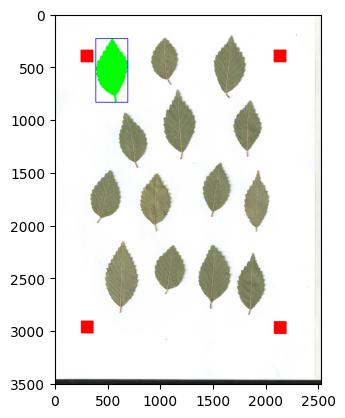

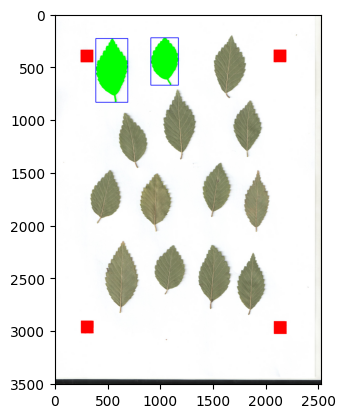

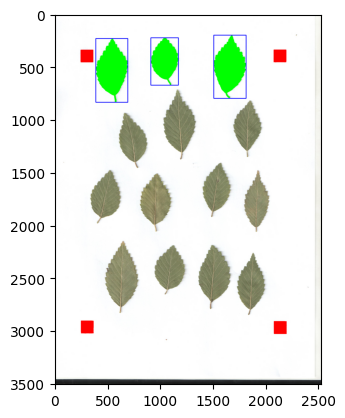

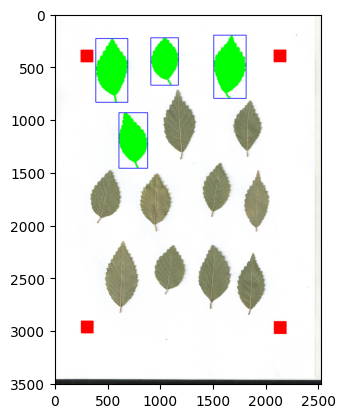

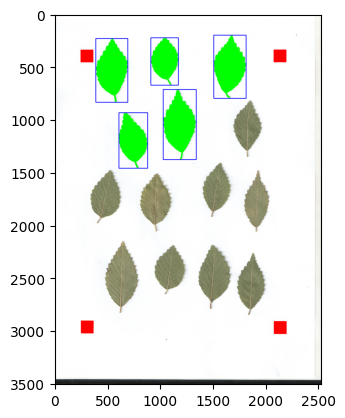

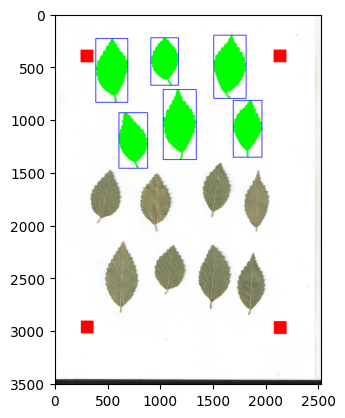

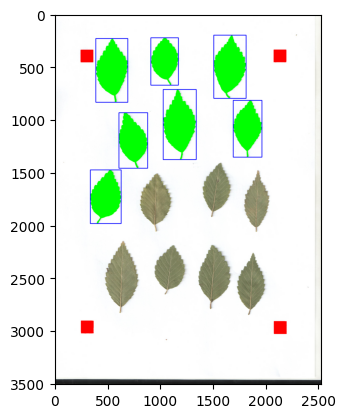

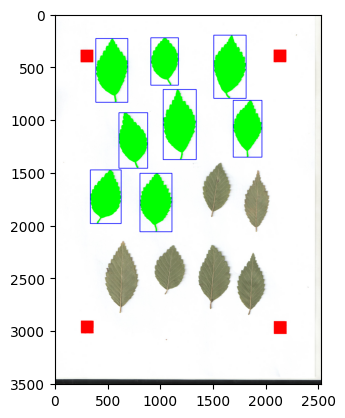

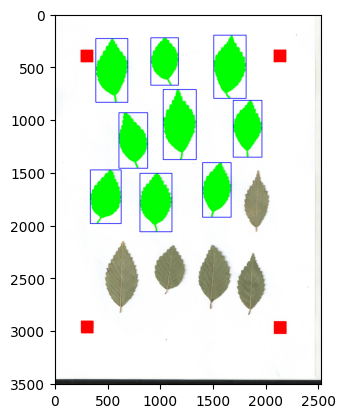

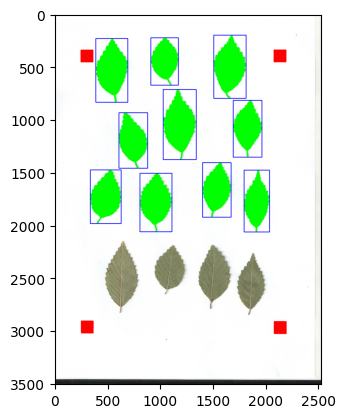

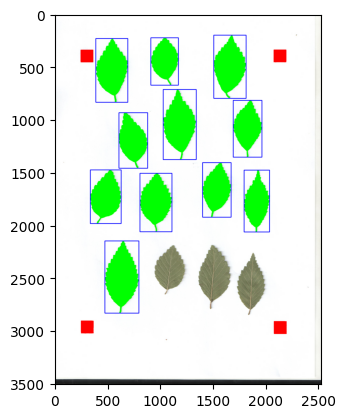

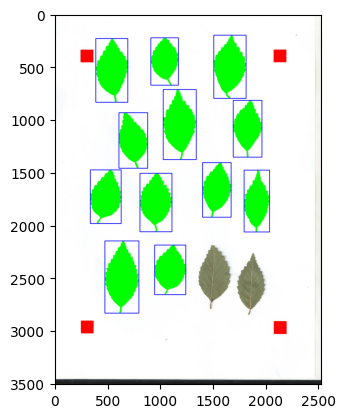

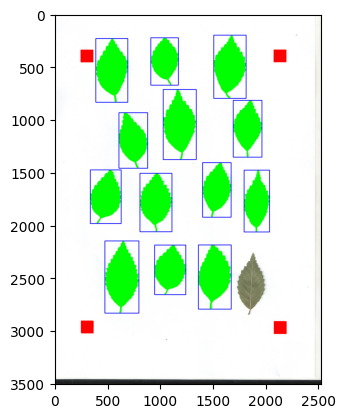

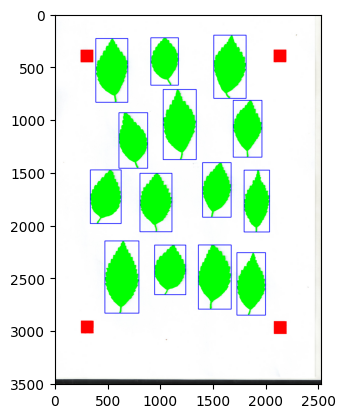

In [29]:
img_path = os.path.join(img_folder, img_names[0])
elm_img_rgb, elm_img_gray = load_image_rgb_grayscale(img_path)

bin_img = binarize(elm_img_gray)
eroded_img = erode_dilate_loop(bin_img)

contours, _ = cv2.findContours(eroded_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

standards, leaves, FIRST_STANDARD_1mm = filter_contours_n_bboxes(contours,
                                                                 side_threshold=100,
                                                                 std_threshold=500)

standards_bboxes, standards_contours = zip(*standards)
standards_centroids = bboxes_to_centroids(standards_bboxes)

leaves_bboxes, leaves_contours = zip(*leaves)
leaves_centroids = bboxes_to_centroids(leaves_bboxes)


# print(len(standards), len(leaves))

# tmp = elm_img_rgb.copy()
# standards_centroids = bboxes_to_centroids(standards_bboxes)
# for c, (cx, cy) in zip(standards_contours, standards_centroids):
#     tmp = cv2.circle(tmp, (cx, cy), radius=10, color=(255, 255, 0), thickness=-1)
#     tmp = cv2.drawContours(tmp, [c], -1, (255, 0, 0), 5)


# for c, (cx, cy) in zip(leaves_contours, leaves_centroids):
#     tmp = cv2.circle(tmp, (cx, cy), radius=20, color=(0, 0, 255), thickness=-1)
#     tmp = cv2.drawContours(tmp, [c], -1, (0, 255, 0), 5)
#     plt.imshow(tmp)
#     plt.show()

# cv2.imwrite('centroids_and_contours.jpg', rgb_to_bgr(tmp))



# tmp = elm_img_rgb.copy()
# for i in idxs:
#     cv2.drawContours(tmp, leaves_contours, i, (255, 0, 0), 5)
#     plt.imshow(tmp)
#     plt.show()

standards_contours, standards_bboxes = sort_bboxes_n_contours_left_to_right_get_bboxes(standards_contours, standards_bboxes, standards_centroids)
leaves_contours, leaves_bboxes = sort_bboxes_n_contours_left_to_right_get_bboxes(leaves_contours, leaves_bboxes, leaves_centroids)
# print(leaves_bboxes[0])
tmp = elm_img_rgb.copy()
gif_contours_in_order_path = os.path.join(articles_images_save_path, 'gif_contours_in_order')
os.makedirs(gif_contours_in_order_path, exist_ok=True)
save_graps_sequentially(rgb_to_bgr(tmp), gif_contours_in_order_path, is_start=True, delete_folder_if_not_empty=True)

for contour, bbox in zip(standards_contours, standards_bboxes):
    tmp = cv2.drawContours(tmp, [contour], -1, (255, 0, 0), -1)
    save_graps_sequentially(rgb_to_bgr(tmp), gif_contours_in_order_path)

for contour, bbox in zip(leaves_contours, leaves_bboxes):
    tmp = cv2.drawContours(tmp, [contour], -1, (0, 255, 0), -1)
    tmp = cv2.drawContours(tmp, [bbox], -1, (0, 0, 255), 5)
    plt.imshow(tmp)
    plt.show()
    save_graps_sequentially(rgb_to_bgr(tmp), gif_contours_in_order_path)





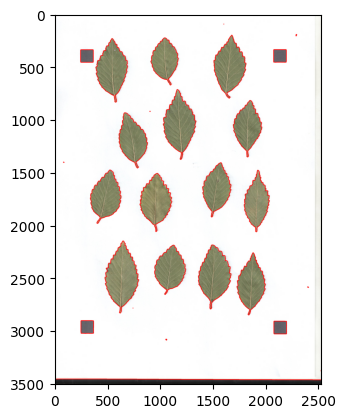

In [30]:
plt.imshow(cv2.drawContours(elm_img_rgb, contours, -1, (255, 0, 0), 5))

In [31]:
leaf_white_bg_imgs = []
transformed_leaf_contours = []
for bbox, contour in zip(leaves_bboxes, leaves_contours):
    x1, y1 = bbox[0][0]
    x2, y2 = bbox[2][0]
    tmp = elm_img_rgb.copy()
    leaf_white_bg, transformed_leaf_contour = crop_add_to_matrix_with_contour_transform(tmp,
                                                                                    x1, y1, x2, y2, contour, padding=100)
    leaf_white_bg_imgs.append(leaf_white_bg)
    transformed_leaf_contours.append(transformed_leaf_contour)
    # plt.imshow(cv2.drawContours(tmp, [transformed_leaf_contour], -1, (255, 0, 0), 5))
    # plt.show()
    # plt.imshow(leaf_white_bg)
    # plt.show()
    # leaf_white_bg = rotate_image_and_fill(leaf_white_bg, transformed_leaf_contour)
    # plt.imshow(leaf_white_bg)
    # plt.show()


In [32]:
len(leaf_white_bg_imgs)

14

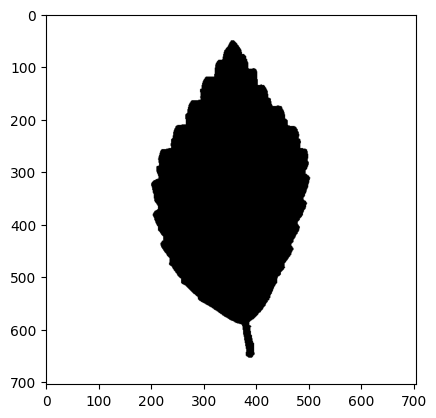

In [33]:
tmp = leaf_white_bg_imgs[0].copy()
tmp_cnt = transformed_leaf_contours[0].copy()

def fill_contour_black(image, contour):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contour], contourIdx=-1, color=255, thickness=cv2.FILLED)
    image[mask == 255] = [0, 0, 0]
    return image

tmp1 = fill_contour_black(tmp, tmp_cnt)
plt.imshow(tmp1)

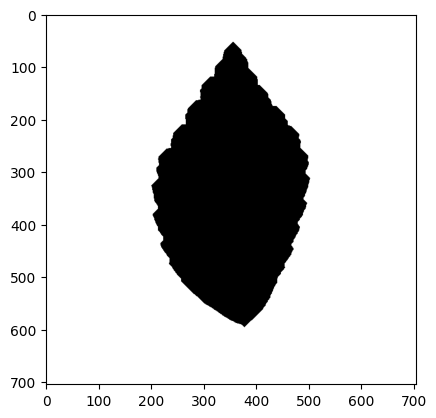

In [34]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
transform_img = cv2.erode(cv2.dilate(tmp1, kernel, iterations=15), kernel, iterations=15)
plt.imshow(transform_img)

In [35]:
transform_img.shape

(704, 704, 3)

25.25 45.25


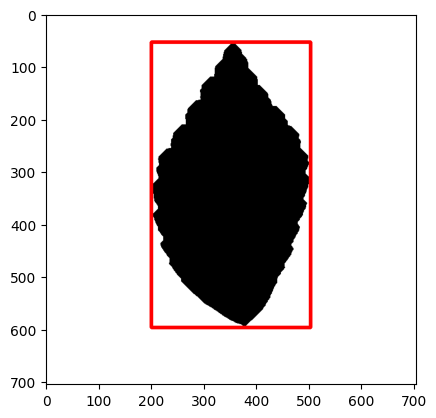

In [38]:
img = cv2.bitwise_not(cv2.cvtColor(transform_img.copy(), cv2.COLOR_RGB2GRAY))
contours, _  = cv2.findContours(img,
                                           cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# print(contour)
bbox = cv2.boundingRect(contours[0])
x, y, w, h = bbox
img = transform_img.copy()
cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 5)
# rect = cv2.minAreaRect(contour[0])
# box = cv2.boxPoints(rect)
# box = box.astype(int)  # Преобразуем в целые числа
# ellipse = cv2.fitEllipse(contours[0])
# # Рисуем эллипс на изображении
# cv2.ellipse(img, ellipse, (0, 255, 0), 5)  # Зеленый цвет, толщина 2

# # Рисуем прямоугольник на изображении
# cv2.drawContours(img, [box], 0, (0, 0, 255), 5)
plt.imshow(img)
print(w/FIRST_STANDARD_1mm, h/FIRST_STANDARD_1mm)

In [45]:
def area_in_mm2(contour):
    area = cv2.contourArea(contour)
    return area / FIRST_STANDARD_1mm ** 2

In [47]:
area_in_mm2(contours[0])

709.2048611111111

### Мб когда-то потом

In [ ]:
import cv2
import numpy as np
import pandas as pd
from scipy.stats import variation  # Для коэффициента вариации

def analyze_horizontal_segments(contour, bounding_box, image):
    """
    Анализирует горизонтальные отрезки пикселов контура.

    Args:
        contour: Контур (NumPy array, как возвращает cv2.findContours).
        bounding_box: Bounding box контура (x, y, width, height).
        image: Изображение с целевым объектом на белом фоне (NumPy array).

    Returns:
        DataFrame: DataFrame с mean, std, variance, coefficient of variation для каждого горизонтального отрезка.
        int: Индекс строки (y-координата), где распределение белых пикселов значительно увеличивается, или None, если не найдено.
    """

    x, y, w, h = bounding_box

    # 1.  Вычисляем центроид контура
    M = cv2.moments(contour)
    if M["m00"] == 0:
        print("Ошибка: Площадь контура равна 0. Невозможно вычислить центроид.")
        return None, None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # 2.  Сохраняем горизонтальные отрезки в массив arr
    arr = []
    for i in range(h):  # Итерируемся по высоте bounding box'а
        y_coord = y + i  # y-координата текущей строки

        # Ограничиваем y_coord, чтобы она не выходила за пределы изображения
        if 0 <= y_coord < image.shape[0]:
            segment = image[y_coord, x:x+w] # Получаем горизонтальный отрезок
            arr.append(segment)
        else:
            # Если y_coord выходит за пределы изображения, добавляем пустой отрезок
            # или можно пропустить этот отрезок.  В данном случае добавим пустой:
            arr.append(np.array([])) # Пустой numpy array

    # 3.  Вычисляем статистику и сохраняем в DataFrame
    data = []
    for segment in arr:
        if segment.size > 0:
            mean = np.mean(segment)
            std = np.std(segment)
            variance = np.var(segment)
            # coefficient of variation
            cv = variation(segment)  # Используем scipy.stats.variation
            data.append([mean, std, variance, cv])
        else:
            # Если отрезок пустой, добавляем NaN значения
            data.append([np.nan, np.nan, np.nan, np.nan])

    df = pd.DataFrame(data, columns=['mean', 'std', 'variance', 'cv'])

    # 4.  Ищем момент, когда распределение белых пикселов значительно увеличивается
    threshold_increase = 1.5 # Настраиваемый порог увеличения (например, увеличение mean в 1.5 раза)
    change_index = None
    for i in range(1, len(df)):
        if not np.isnan(df['mean'][i]) and not np.isnan(df['mean'][i-1]):  # Игнорируем NaN значения
            if df['mean'][i] > threshold_increase * df['mean'][i-1]:
                change_index = y + i  # y-координата, где произошло изменение
                break

    return df, change_index

# Получите bounding box
x, y, w, h = cv2.boundingRect(tmp_cnt)
bounding_box = (x, y, w, h)

# Анализируйте горизонтальные отрезки
df, change_index = analyze_horizontal_segments(tmp_cnt, bounding_box, tmp.copy())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_plateau_to_descent(data, alpha, plateau_threshold, min_plateau_length, descent_threshold, min_descent_length):
    """
    Находит момент перехода от плато к резкому спуску в данных.

    Аргументы:
        data: Массив данных.
        alpha: Параметр сглаживания EMA.
        plateau_threshold: Пороговое значение для разностей на плато.
        min_plateau_length: Минимальная длина плато.
        descent_threshold: Пороговое значение для начала спуска.
        min_descent_length: Минимальная длина спуска.

    Возвращает:
        Индекс начала спуска после плато, или None, если не найдено.
    """

    # 1. Сглаживание EMA
    smoothed_data = np.zeros_like(data, dtype=float)
    smoothed_data[0] = data[0]
    for i in range(1, len(data)):
        smoothed_data[i] = alpha * data[i] + (1 - alpha) * smoothed_data[i-1]

    # 2. Определение плато
    differences = np.diff(smoothed_data)
    plateau_indices = np.where(np.abs(differences) < plateau_threshold)[0]

    # Находим участки плато (последовательные индексы)
    plateaus = []
    start_plateau = None
    for i in range(len(plateau_indices)):
        if start_plateau is None:
            start_plateau = plateau_indices[i]
        elif plateau_indices[i] == plateau_indices[i-1] + 1:
            pass  # Продолжаем плато
        else:
            # Конец плато
            end_plateau = plateau_indices[i-1]
            if (end_plateau - start_plateau + 1) >= min_plateau_length:
                plateaus.append((start_plateau, end_plateau))
            start_plateau = plateau_indices[i]

    # Обработка последнего плато
    if start_plateau is not None:
        end_plateau = plateau_indices[-1]
        if (end_plateau - start_plateau + 1) >= min_plateau_length:
            plateaus.append((start_plateau, end_plateau))

    # 3. Обнаружение начала спуска после плато
    for start_plateau, end_plateau in plateaus:
        # Ищем индекс сразу после плато
        start_descent_index = end_plateau + 1

        # Проверяем, что у нас достаточно данных для анализа спуска
        if start_descent_index + min_descent_length >= len(differences):
            continue  # Недостаточно данных для проверки спуска

        # Проверяем, что начинается спуск
        valid_descent = True
        for i in range(start_descent_index, start_descent_index + min_descent_length):
            if differences[i] >= -descent_threshold:
                valid_descent = False
                break

        if valid_descent:
            return start_descent_index + 1 #+1 because of diff()

    return None  # Не найдено перехода от плато к спуску


data = np.array([10, 10.1, 9.9, 10.2, 10, 9.8,  # Плато
                   9, 8, 7, 6, 5, 4, 3, 2, 1])  # Спуск
data = smoothed_sma[::-1]
#Агрессивные настройки для начала отладки
alpha = 0.9 #Минимальное сглаживание
plateau_threshold = 0.5 #Широкое плато
min_plateau_length = 1  #Короткий плато
descent_threshold = 0.1 #Чувствительный к спуску
min_descent_length = 1  #Короткий спуск

descent_index = find_plateau_to_descent(data, alpha, plateau_threshold, min_plateau_length, descent_threshold, min_descent_length)

if descent_index is not None:
    print("Начало спуска после плато:", descent_index)
else:
    print("Переход от плато к спуску не найден")

descent_index = find_plateau_to_descent(data, alpha, plateau_threshold, min_plateau_length, descent_threshold, min_descent_length)

if descent_index is not None:
    print("Начало спуска после плато:", descent_index)
else:
    print("Переход от плато к спуску не найден")

# Визуализация
plt.plot(data)
if descent_index is not None:
    plt.axvline(x=descent_index, color='r', linestyle='--', label='Начало спуска')
plt.legend()
plt.show()

NameError: name 'smoothed_sma' is not defined

In [ ]:
len(smoothed_sma) - 60


605

Plateau found: Start=0, End=6, Value=238.2143427658603
Plateau found: Start=7, End=9, Value=237.5926517571885
Plateau found: Start=286, End=288, Value=11.724840255591056
Plateau found: Start=289, End=292, Value=11.140974440894567
Plateau found: Start=293, End=307, Value=10.718690095846645
Plateau found: Start=308, End=310, Value=10.041134185303518
Plateau found: Start=311, End=321, Value=9.49862038919547
Plateau found: Start=322, End=324, Value=10.448482428115014
Plateau found: Start=325, End=328, Value=11.039137380191693
Plateau found: Start=329, End=342, Value=11.628337517115472
Plateau found: Start=343, End=345, Value=12.098242811501597
Plateau found: Start=370, End=372, Value=21.331469648562305
Plateau found: Start=373, End=379, Value=21.935702875399357
Plateau found: Start=380, End=384, Value=22.53857827476038
Plateau found: Start=385, End=388, Value=23.15774760383386
Plateau found: Start=389, End=392, Value=23.778953674121404
Plateau found: Start=393, End=395, Value=24.3865814696

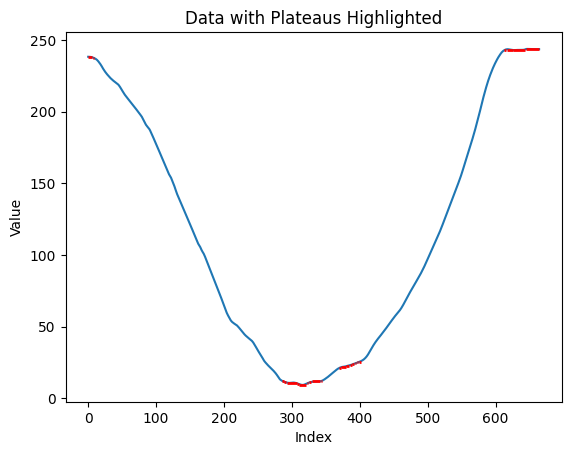

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_plateaus(data, threshold=5.0, min_length=5):
    plateaus = []
    start_index = None
    current_value = None

    for i in range(len(data)):
        if start_index is None:
            start_index = i
            current_value = data[i]
        else:
            if abs(data[i] - current_value) <= threshold:
                # Still on the plateau
                pass
            else:
                # End of the plateau
                end_index = i - 1
                if (end_index - start_index + 1) >= min_length:
                    plateau_value = np.mean(data[start_index:end_index+1])
                    plateaus.append((start_index, end_index, plateau_value))

                # Start a new plateau
                start_index = i
                current_value = data[i]

    # Handle the last plateau (if any)
    if start_index is not None:
        end_index = len(data) - 1
        if (end_index - start_index + 1) >= min_length:
            plateau_value = np.mean(data[start_index:end_index+1])
            plateaus.append((start_index, end_index, plateau_value))

    return plateaus


# Example usage (assuming you have the data from the image in a NumPy array called 'data'):

# Dummy data mimicking the image (replace with your actual data)
data = np.array([250, 240, 230, 220, 210, 200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245]) #Added a plateau at the end

data = smoothed_sma
plateaus = find_plateaus(data, threshold=0.5, min_length=3) # Play around with threshold and min_length!

for start, end, value in plateaus:
    print(f"Plateau found: Start={start}, End={end}, Value={value}")

# Visualize the results (optional)
plt.plot(data)
for start, end, value in plateaus:
    plt.hlines(value, start, end, color='red', linewidth=2) # mark the plateaus
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Data with Plateaus Highlighted")
plt.show()

Индексы точек перегиба: []


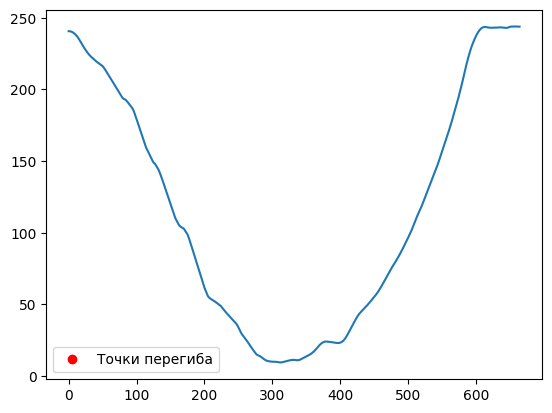

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_inflection_points(data, threshold):
    """
    Находит точки перегиба в данных, основываясь на абсолютной величине второй производной.

    Аргументы:
        data: Массив данных.
        threshold: Пороговое значение для величины второй производной.

    Возвращает:
        Массив индексов, соответствующих точкам перегиба.
    """

    # 1. Вычисляем вторую производную (численно)
    derivative = np.diff(data, n=2)  # n=2 вычисляет вторую производную

    # 2. Находим индексы, где абсолютное значение второй производной превышает пороговое значение
    inflection_indices = np.where(np.abs(derivative) > threshold)[0] + 1 #Added 1 to account for n=2 diff

    return inflection_indices

# Пример использования:
data = np.array([x**3 for x in np.linspace(-5, 5, 100)]) # Пример с точкой перегиба в 0
data = smoothed_sma
threshold = 5  # Adjust this!
inflection_indices = find_inflection_points(data, threshold)

print("Индексы точек перегиба:", inflection_indices)

# Визуализация
plt.plot(data)
plt.plot(inflection_indices, data[inflection_indices], 'ro', label='Точки перегиба')
plt.legend()
plt.show()

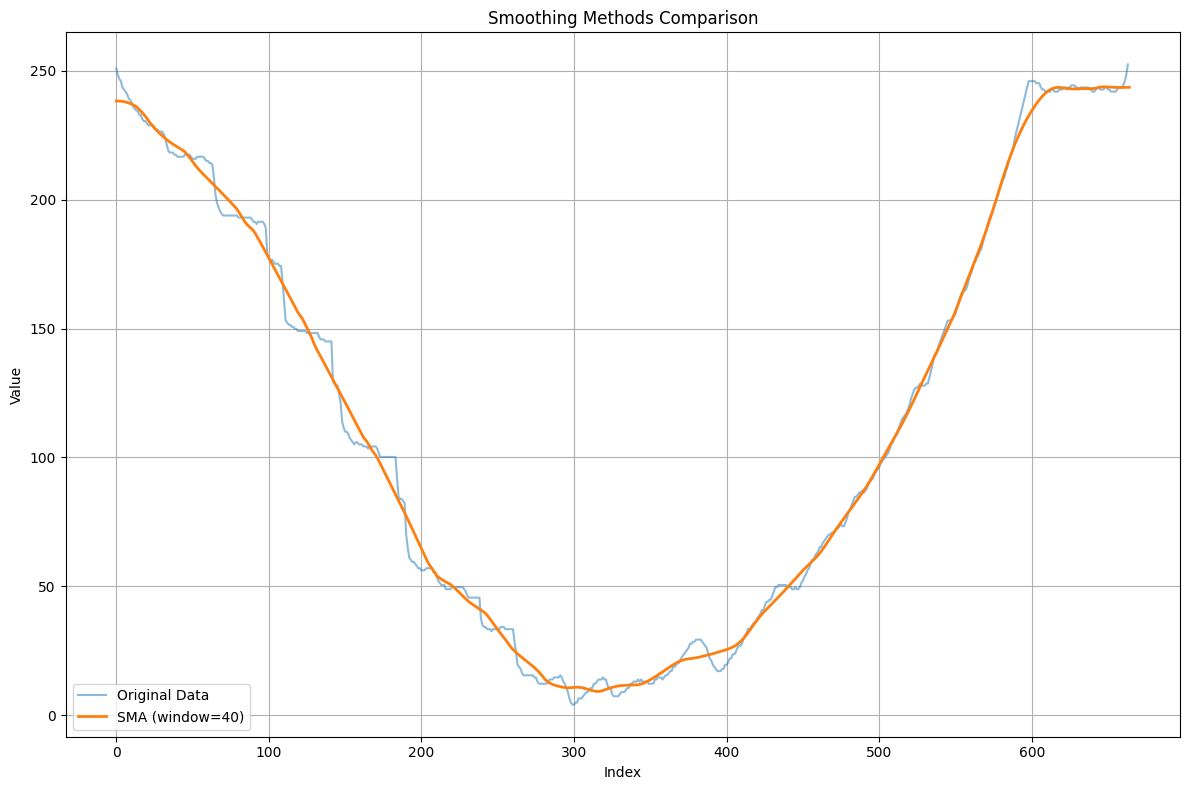

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def moving_average(data, window_size):
  if window_size > len(data):
    raise ValueError("Размер окна не может быть больше длины данных.")

  padding = window_size // 2
  padded_data = np.pad(data, (padding, padding), mode='reflect')
  smoothed_data = np.convolve(padded_data, np.ones(window_size), 'valid') / window_size
  return smoothed_data

def weighted_moving_average(data, weights):
  if len(weights) > len(data):
    raise ValueError("Длина весов не может быть больше длины данных.")
  if np.sum(weights) != 1:
    weights = weights / np.sum(weights)

  padding = len(weights) // 2
  padded_data = np.pad(data, (padding, padding), mode='reflect')
  smoothed_data = np.convolve(padded_data, weights, 'valid')
  return smoothed_data

def exponential_moving_average(data, alpha):
  smoothed_data = np.zeros_like(data, dtype=float)
  smoothed_data[0] = data[0]
  for i in range(1, len(data)):
    smoothed_data[i] = alpha * data[i] + (1 - alpha) * smoothed_data[i-1]
  return smoothed_data


def median_smoothing(data, window_size):
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd for median filtering.")

    padded_data = np.pad(data, (window_size // 2, window_size // 2), mode='reflect')
    smoothed_data = median_filter(padded_data, size=window_size, mode='constant') # Use constant mode.
    return smoothed_data[window_size//2 : -window_size//2] # Unpad

# Example usage:
data = df['mean'].values
window_size = 40
alpha = 0.7

# Define weights for WMA (example: triangular weights)
weights = np.bartlett(window_size) #triangular kernel
weights /= weights.sum() # Normalize to sum to 1

smoothed_sma = moving_average(data, window_size)
smoothed_wma = weighted_moving_average(data, weights)
smoothed_ema = exponential_moving_average(data, alpha)
smoothed_median = median_smoothing(data, 5)


# Plot all results
plt.figure(figsize=(12, 8))  # Adjust figure size
plt.plot(data, label='Original Data', alpha=0.5)
plt.plot(smoothed_sma, label=f'SMA (window={window_size})', linewidth=2)
# plt.plot(smoothed_wma, label='WMA', linewidth=2)
# plt.plot(smoothed_ema, label=f'EMA (alpha={alpha})', linewidth=2)
# plt.plot(smoothed_median, label='Median Filter', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Smoothing Methods Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout() #Adjust layout to not overlap text
plt.show()

<Axes: >

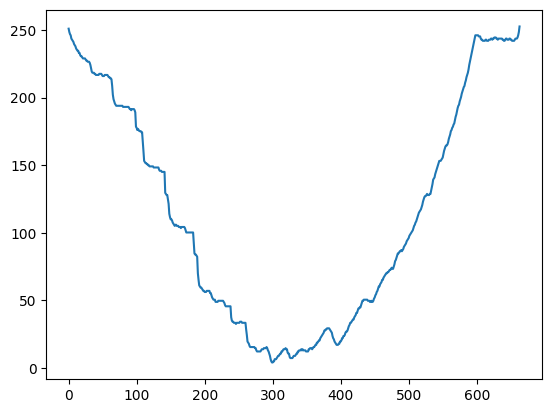

In [ ]:
df['mean'].plot()

In [ ]:

import cv2
import numpy as np
import pandas as pd
from scipy.stats import variation  # Для коэффициента вариации

def analyze_and_cut_contour(contour, bounding_box, image, tolerance=5):
    """
    Анализирует горизонтальные отрезки, отсекает контур и соединяет точки.

    Args:
        contour: Контур (NumPy array, как возвращает cv2.findContours).
        bounding_box: Bounding box контура (x, y, width, height).
        image: Изображение с целевым объектом на белом фоне (NumPy array).
        tolerance: Допуск для определения "почти перестало меняться" (в пикселях).

    Returns:
        NumPy array: Новый контур после отсечения и соединения.
        int: y_coord, где был произведен отсечение, или None, если отсечение не произошло.
    """

    x, y, w, h = bounding_box

    # 1. Вычисляем центроид
    M = cv2.moments(contour)
    if M["m00"] == 0:
        print("Ошибка: Площадь контура равна 0. Невозможно вычислить центроид.")
        return None, None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # 2. Сохраняем горизонтальные отрезки и вычисляем статистику
    arr = []
    data = []
    for i in range(cy, h):
        y_coord = cy + i
        if 0 <= y_coord < image.shape[0]:  # Проверка границ
            segment = image[y_coord, x:x+w]
            arr.append(segment)
            mean = np.mean(segment)
            std = np.std(segment)
            variance = np.var(segment)
            cv = variation(segment)
            data.append([mean, std, variance, cv])
        else:
            arr.append(np.array([]))
            data.append([np.nan, np.nan, np.nan, np.nan]) # NaN для пустых отрезков


    df = pd.DataFrame(data, columns=['mean', 'std', 'variance', 'cv'])

    # 3. Ищем момент, когда распределение белых пикселов почти перестало меняться
    y_coord_cutoff = None
    for i in range(1, len(df) - tolerance):  # Учитываем tolerance, чтобы смотреть вперед
        # Вычисляем разницу между средними значениями на протяжении tolerance пикселей
        mean_diff = np.abs(df['mean'][i:i+tolerance].diff()).sum()
        if np.isnan(mean_diff):  # Пропускаем, если есть NaN значения
           continue

        # Если разница меньше определенного порога, считаем, что распределение почти не меняется
        if mean_diff < 0.1 * tolerance:  # 0.1 - настраиваемый порог (подберите его)
            y_coord_cutoff = y + i
            break
    y_coord_cutoff = 605
    # 4. Отсекаем часть контура, который выходит за y_coord_cutoff
    if y_coord_cutoff is not None:
        new_contour = contour[contour[:, 0, 1] <= y_coord_cutoff]

        # 5. Соединяем точки основного контура (который верхний)
        if len(new_contour) > 0: # Проверка, что после отсечения что-то осталось
            # Находим самую левую и правую точки на новом контуре
            leftmost_idx = np.argmin(new_contour[:, 0, 0])
            rightmost_idx = np.argmax(new_contour[:, 0, 0])

            # Находим координаты этих точек
            leftmost_point = new_contour[leftmost_idx][0]
            rightmost_point = new_contour[rightmost_idx][0]

            # Создаем точки для соединения.  Можно просто горизонтальную линию,
            # или более сложную кривую (например, параболу).  Здесь - просто линия:
            new_point1 = np.array([[leftmost_point[0], y_coord_cutoff]])
            new_point2 = np.array([[rightmost_point[0], y_coord_cutoff]])

            # Добавляем точки соединения в контур
            new_contour = np.concatenate((new_contour, [new_point1], [new_point2]))

            # Сортируем точки контура по x-координате (это упрощенный подход;
            # в реальной задаче потребуется более сложный алгоритм сортировки
            # для учета формы контура).
            new_contour = new_contour[new_contour[:, 0, 0].argsort()]

            # Преобразуем в нужный формат (необходимо для cv2.drawContours и других функций)
            new_contour = new_contour.reshape((-1, 1, 2)).astype(np.int32)

        else:
          new_contour = np.array([]) # Контур пуст после отсечения
          print("Внимание: контур пуст после отсечения.")


    else:
        new_contour = contour # Если y_coord_cutoff is None
        print("Распределение не перестало меняться, отсечение не произошло.")


    return new_contour, y_coord_cutoff


x, y, w, h = cv2.boundingRect(tmp_cnt)
tmp_bbox = (x, y, w, h)

# Анализируйте горизонтальные отрезки
df, change_index = analyze_and_cut_contour(tmp_cnt, tmp_bbox, tmp1)

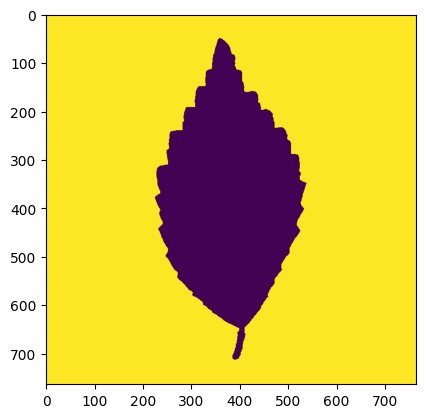

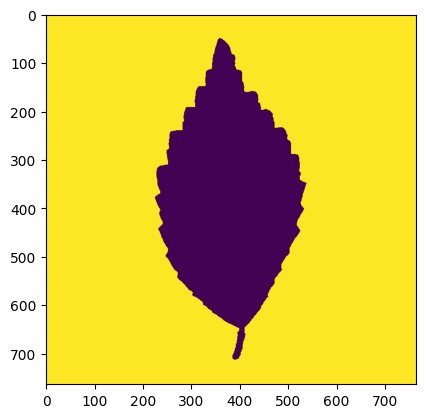

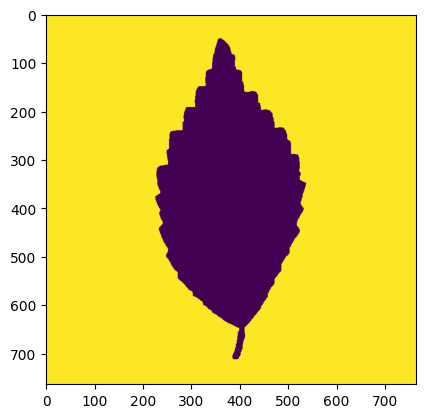

In [ ]:
import cv2
import numpy as np

def connect_contours_morph(img, kernel_size):


    _, binary_image = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    # Определение ядра для морфологической операции
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # Морфологическое замыкание
    closing = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # Отображаем результаты
    plt.imshow(img)
    plt.show()
    plt.imshow(binary_image)
    plt.show()
    plt.imshow(closing)
    plt.show()

# Пример использования
connect_contours_morph(cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY), (5, 5)) # Замените путь и размер ядра

In [ ]:
import cv2
import numpy as np

def find_base_points(bin_img, contour, distance_threshold, order_threshold):

    best_point1 = None
    best_point2 = None
    min_distance = float('inf')  # Изначально устанавливаем бесконечное расстояние

    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            order_difference = abs(i - j)
            point1 = contour[i][0]
            point2 = contour[j][0]
            distance = np.linalg.norm(point1 - point2)  # Евклидово расстояние

            if order_difference > order_threshold and distance < distance_threshold:
                # Это потенциально подходящая пара точек, проверяем, лучше ли она предыдущей
                if distance < min_distance:
                    min_distance = distance
                    best_point1 = tuple(point1)
                    best_point2 = tuple(point2)


    if best_point1 and best_point2:
        print(f"Найдены точки основания корешка: {best_point1}, {best_point2}")
        return best_point1, best_point2
    else:
        print("Не удалось найти подходящие точки.")
        return None

distance_threshold = float('inf')
order_threshold = 50     # Минимальная разница в индексах (настройте)


points = find_base_points(image_path, distance_threshold, order_threshold)

if points:
    img = cv2.imread(image_path)
    cv2.circle(img, points[0], 5, (0, 0, 255), -1)  # Рисуем красную точку
    cv2.circle(img, points[1], 5, (0, 0, 255), -1)  # Рисуем красную точку
    plt.imshow(img)

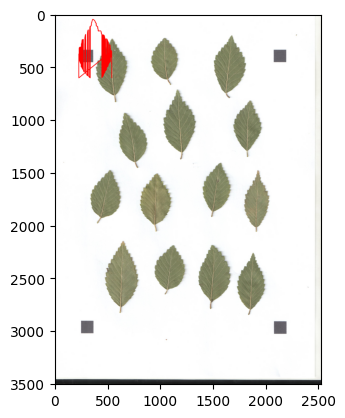

In [ ]:
plt.imshow(cv2.drawContours(elm_img_rgb.copy(), [df], -1, (255, 0, 0), 5))

<Axes: >

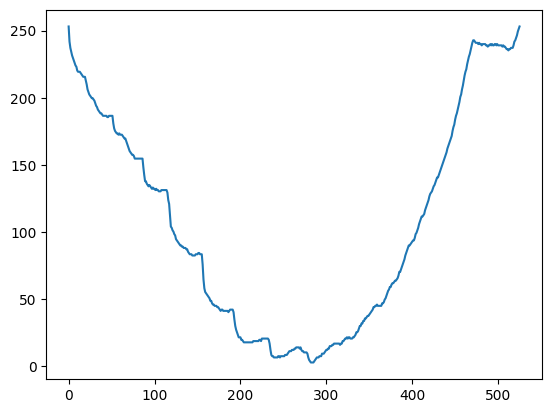

In [ ]:
df['mean'].plot()

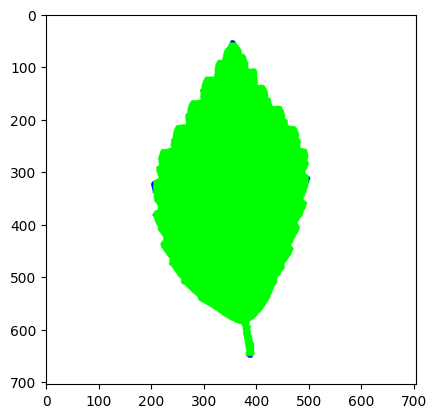

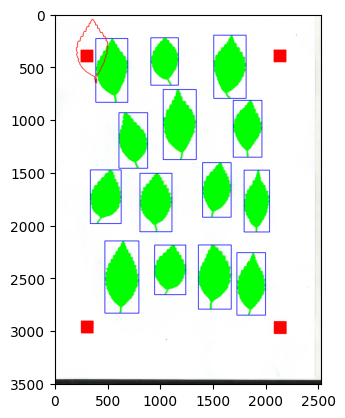

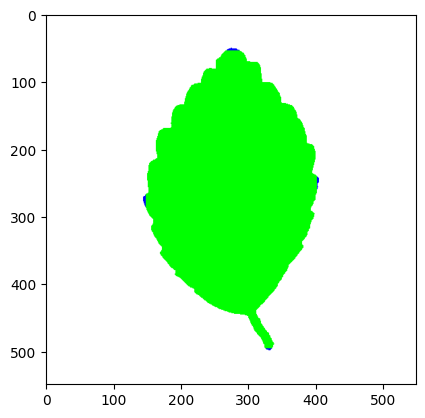

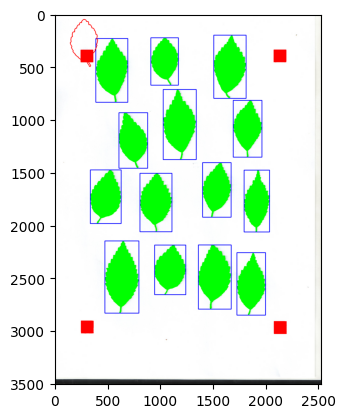

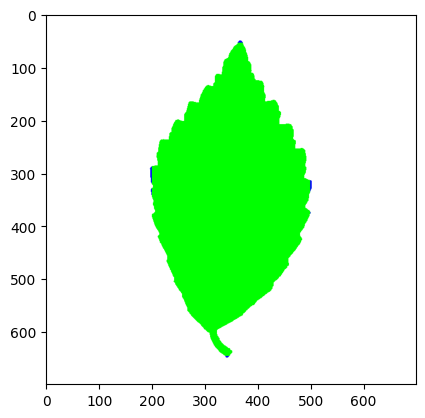

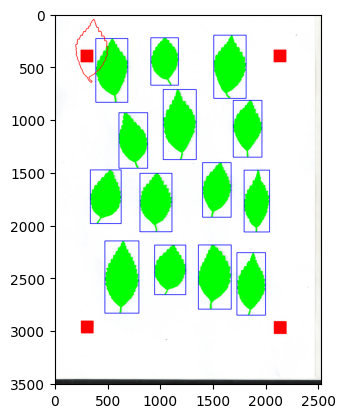

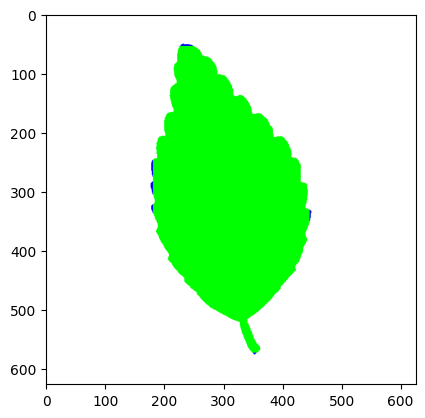

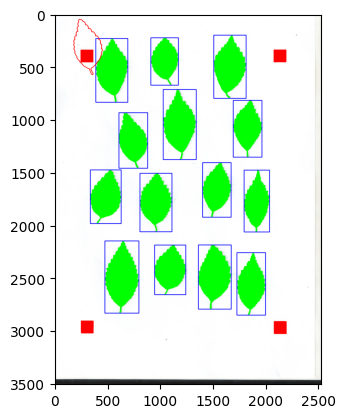

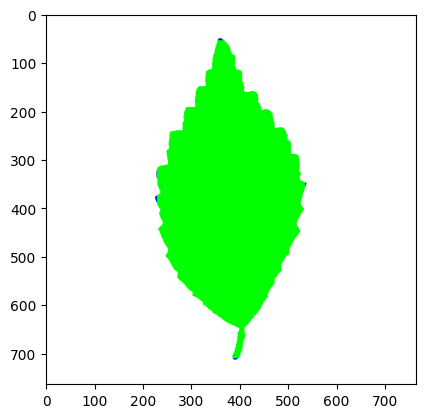

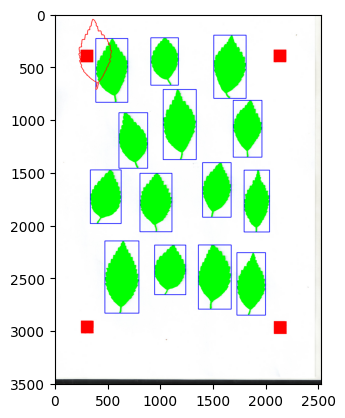

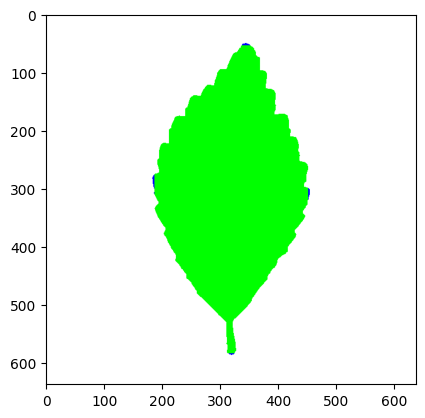

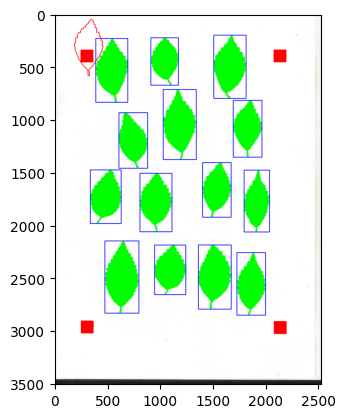

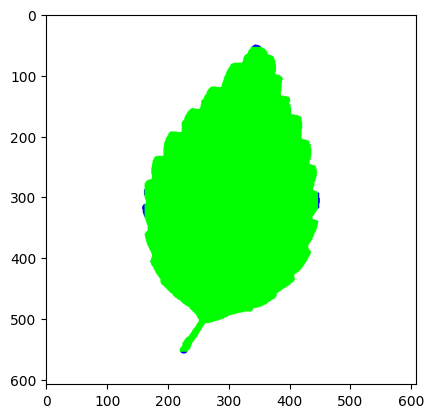

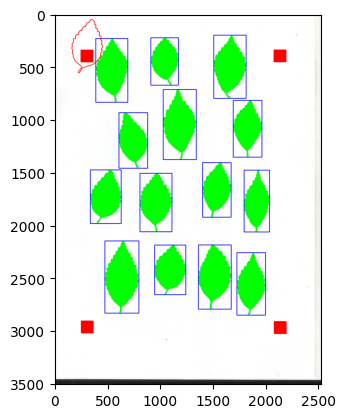

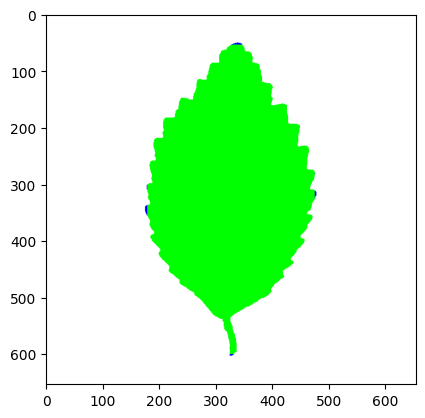

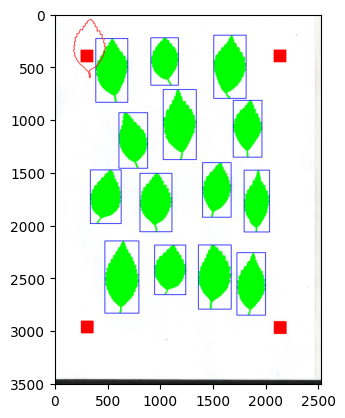

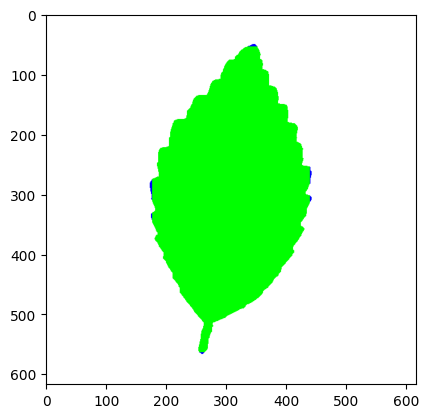

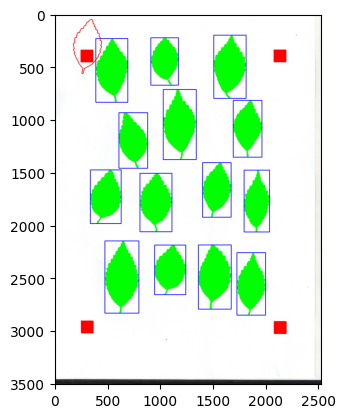

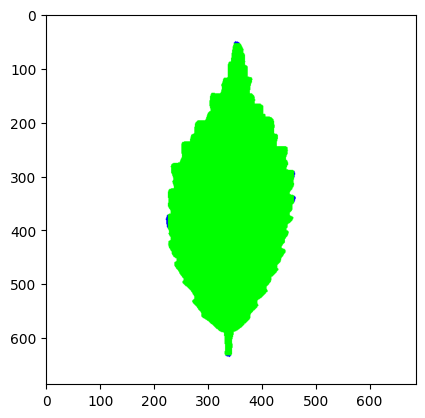

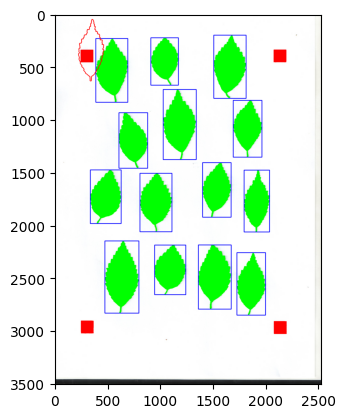

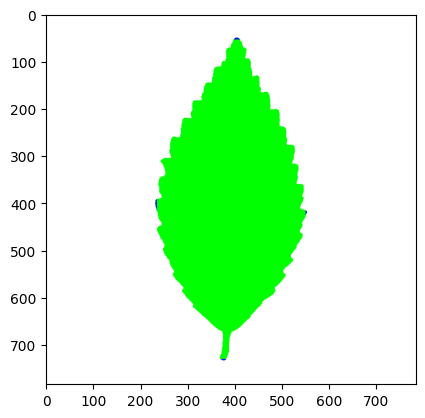

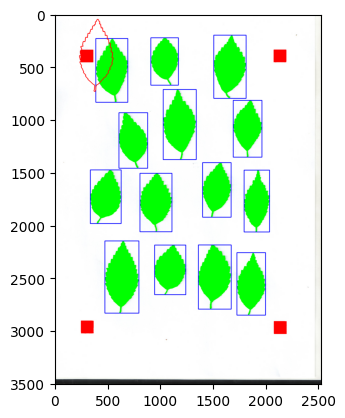

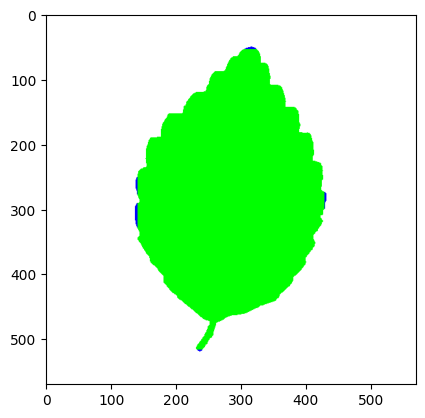

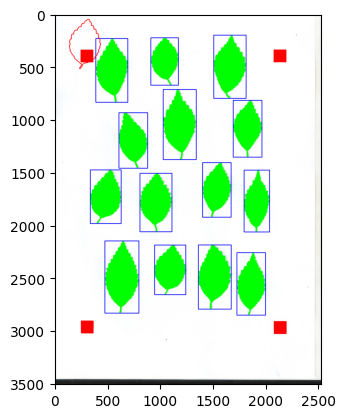

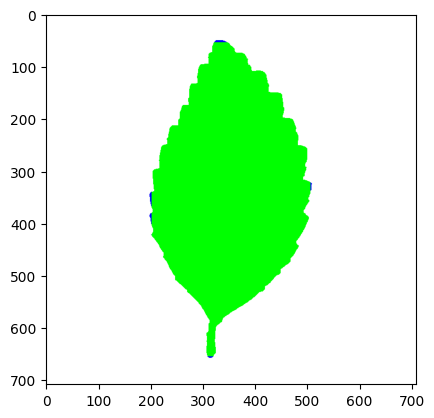

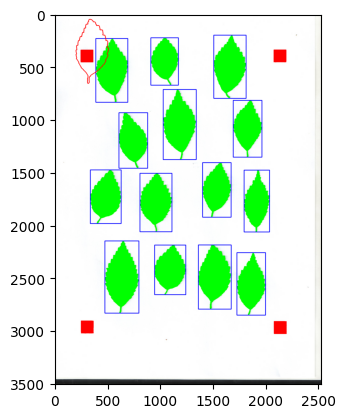

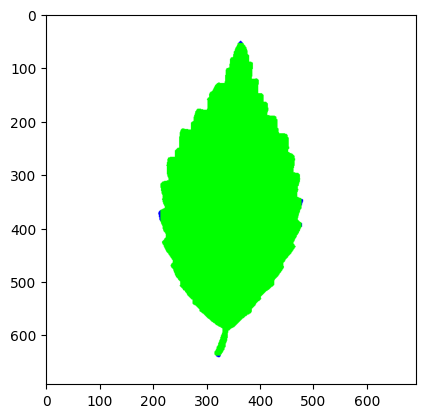

KeyboardInterrupt: 

In [ ]:
def fill_contour_black(image, contour):
    mask = image != (255, 255, 255)
    image[mask] = (0, 0, 0)
    return image

In [ ]:
images_folder_to_gif(gif_contours_in_order_path, os.path.join(path_to_gifs, 'contours_in_order.gif'), duration=1000)

In [ ]:
# выделить лист
# убрать черешокы
# посчитать длину, оценить ширину, площадь.

In [ ]:
contours[3]

array([[[ 247, 2905]],

       [[ 351, 2905]],

       [[ 352, 2906]],

       [[ 363, 2906]],

       [[ 364, 2907]],

       [[ 364, 2911]],

       [[ 365, 2912]],

       [[ 365, 2972]],

       [[ 364, 2973]],

       [[ 364, 2983]],

       [[ 365, 2984]],

       [[ 364, 2985]],

       [[ 364, 2990]],

       [[ 365, 2991]],

       [[ 364, 2992]],

       [[ 364, 2997]],

       [[ 365, 2998]],

       [[ 365, 3000]],

       [[ 364, 3001]],

       [[ 364, 3007]],

       [[ 365, 3008]],

       [[ 364, 3009]],

       [[ 364, 3015]],

       [[ 365, 3016]],

       [[ 365, 3022]],

       [[ 364, 3023]],

       [[ 364, 3024]],

       [[ 363, 3025]],

       [[ 352, 3025]],

       [[ 351, 3026]],

       [[ 350, 3025]],

       [[ 345, 3025]],

       [[ 344, 3026]],

       [[ 337, 3026]],

       [[ 336, 3025]],

       [[ 328, 3025]],

       [[ 327, 3026]],

       [[ 322, 3026]],

       [[ 321, 3025]],

       [[ 312, 3025]],

       [[ 311, 3026]],

       [[ 310, 3

In [ ]:
thresh1 = np.where(eroded_image == 255, 1, 0)

NameError: name 'eroded_image' is not defined

In [ ]:
mask = np.zeros(elm_img_rgb.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, cs, 2, 255, cv2.FILLED)
# Инвертирование маски: контуры черные, все остальное - белое
mask_inv = cv2.bitwise_not(mask)

# Сохраняем исходное изображение внутри контуров
image_masked = cv2.bitwise_and(elm_img_rgb, elm_img_rgb, mask=mask)
# Создание белого фона
white_background = np.ones_like(elm_img_rgb, dtype=np.uint8) * 255

# Добавляем белый фон за пределами контуров
background_masked = cv2.bitwise_and(white_background, white_background, mask=mask_inv)

# Объединяем контуры с исходным изображением и белый фон
final_result = cv2.bitwise_or(image_masked, background_masked)
plt.imshow(final_result)

In [ ]:
dst = elm_img_rgb.copy()

In [ ]:
x, y = np.where(thresh1 != 0)
pts = zip(x, y)
for pt in pts:
   dst[pt] = (255, 255, 255)

In [ ]:
plt.imshow(dst)

In [ ]:
cv2.imwrite('turcz_bin.jpg', cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [ ]:
print(len(contours))

In [ ]:
plt.imshow(cv2.drawContours(elm_img_rgb, contours, -1, (0,255,0), 5))

In [ ]:
tmp = eroded_img.copy()

In [ ]:
[3, 20, 19, 2]

In [ ]:
for i in [3, 20, 19, 2]:
  plt.imshow(cv2.drawContours(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB), contours, i, (0,255,0), -1))
  plt.show()

In [ ]:
plt.imshow(eroded_image)

In [ ]:
contours, hierarchy = cv2.findContours(eroded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
plt.imshow(elm_img_rgb)

In [ ]:
cv2.rectangle(elm_img_rgb, (1397, 1408), (1397+270, 1408+517), (255, 0, 0), 5)

In [ ]:
len(contours)

In [ ]:
cp = eroded_image.copy()

In [ ]:
figure, axes = plt.subplots(1, 3)
axes[0].imshow(cv2.drawContours(eroded_image, contours, -1, (156,255,156), 5)[0:1000, 0:750])
axes[1].imshow(thresh1[0:1000, 0:750])
axes[2].imshow(elm_img[0:1000, 0:750])

In [ ]:
plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), cs, -1, (0,255,0), -1))

In [ ]:
import time

In [ ]:
for i in range(len(cs)):
  plt.imshow(cv2.drawContours(cv2.cvtColor(eroded_image, cv2.COLOR_GRAY2RGB), cs, i, (0,255,0), -1))
  plt.show()
  time.sleep(1)

In [ ]:
 cv2.connectedComponentsWithStats(eroded_image, 4, cv2.CV_32S)